# Decision Tree Lab

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from math import log2
from typing import List, Dict, Set, Optional

## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly.

In [2]:
class Node:
    def __init__(self, X: np.ndarray, y: np.ndarray, available_features: Set[int], col_names: Optional[List[str]]=None):
        self.X = X
        self.y = y
        self.available_features = available_features
        self.col_names = col_names
        
        self.split_feature: int = None
        self.children: Dict[Optional[int,str],Node] = None
        self.info_gain: float = np.nan
        self.prediction = None
        
        if len(np.unique(y)) == 1:
            self.prediction = y[0]
        elif available_features != 0:
            self.prediciton = y[np.argmax(np.unique(y, return_counts=True)[1])]
        if self.col_names is None:
            self.col_names = list(range(len(X.T) + 1))
            
    def __str__(self, indent=0):
        if self.prediction is not None or not self.children:
            return f"{'   '*indent}prediction: {self.prediction}\n"
        output_str = ""
        for value, child in self.children.items():
            output_str += f"{'   '*indent}{self.col_names[self.split_feature]} = {value}, Information Gain = {round(self.info_gain,3)}\n"
            output_str += child.__str__(indent+1)
        return output_str
            
    def split(self):
        info_gains = self.calc_info_gain()
        split_col = min(info_gains, key=info_gains.get)
        self.info_gain = self.calc_tot_entropy() - info_gains[split_col]
        self._create_children(split_col)
        
    def calc_tot_entropy(self) -> float:
        _, counts = np.unique(self.y, return_counts=True)
        return -sum(count/len(self.y)*log2(count/len(self.y)) if count/len(self.y) else 0 for count in counts)
    
    def calc_info_gain(self) -> Dict[int, float]:
        info_gains = dict()
        for col in self.available_features:
            score = 0
            for X_attr in np.unique(self.X[:,col]):
                X_cols = np.where(self.X[:,col] == X_attr)[0]
                entropies = list()
                for Y_attr in np.unique(self.y):
                    Y_cols = np.where(self.y == Y_attr)[0]
                    val = len([idx for idx in Y_cols if idx in X_cols])/len(X_cols)
                    entropies.append(-val * log2(val) if val else 0)
                score += len(X_cols)/len(self.X) * sum(entropies)
            info_gains[col] = score
        return info_gains
    
    def _create_children(self, col) -> None:
        self.children = dict()
        self.split_feature = col
        new_available = self.available_features - set([col])
        for attr in np.unique(self.X[:, col]):
            target_rows = np.where(self.X[:, col] == attr)[0]
            self.children[attr] = Node(self.X[target_rows,:], self.y[target_rows], new_available, self.col_names)
            


In [3]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, data, col_names = None):
        self.X = data[:,:-1]
        self.y = data[:,-1]
        self.root: Node= Node(self.X, self.y, set(range(len(self.X.T))), col_names)
        

    def fit(self):
        curr_node = self.root
        if curr_node.prediction is None:
            curr_node.split()
            for child_node in curr_node.children.values():
                self._fit_recursive(child_node)
        return self
    
    def _fit_recursive(self, curr_node):
        if curr_node.prediction is None:
            curr_node.split()
            for child_node in curr_node.children.values():
                self._fit_recursive(child_node)
        # return self

    def predict(self, X):
        predicted = list()
        for test in X:
            predicted.append(self._predict_helper(test, self.root))
        return np.array(predicted)
    
    def _predict_helper(self, test, curr_node):
        if curr_node.prediction is not None:
            return curr_node.prediction
        
        child_value = test[curr_node.split_feature]
        if child_value not in curr_node.children:
            y_counts = dict(zip(*np.unique(curr_node.y, return_counts=True)))
            return max(y_counts, key=y_counts.get)
        
        return self._predict_helper(test, curr_node.children[child_value])
    

    def score(self, data):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        y_guess = self.predict(data[:,:-1])
        y= data[:,-1]
        return sum(y==y_guess)/len(y)
        # return [(y_i, y_guess_i) for y_i, y_guess_i in zip(y, y_guess) if y_i != y_guess_i]
        # return y==y_guess
    


## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset (lenses.arff)](https://byu.instructure.com/courses/14142/files?preview=4622251)

Test your model on the lenses test set: [Debug Test Dataset (lenses_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622254)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260)

*NOTE: The [Lenses Prediction (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic:
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope:
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic:
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [4]:
# Load debug training data 
data, meta = arff.loadarff("data/lenses.arff")
data = np.array([[*row] for row in data])
data

# Train Decision Tree
clfr = DTClassifier(data, meta.names())
clfr.fit()

# Load debug test data
test_data, _ = arff.loadarff("data/lenses_test.arff")
test_data = np.array([[*row] for row in test_data])
print("score = ", clfr.score(test_data))

print(clfr.root)



# Predict and compute model accuracy


# Print the information gain of every split you make.

score =  0.3333333333333333
tear_prod_rate = b'normal', Information Gain = 0.549
   astigmatism = b'no', Information Gain = 0.77
      age = b'pre_presbyopic', Information Gain = 0.317
         prediction: b'soft'
      age = b'presbyopic', Information Gain = 0.317
         spectacle_prescrip = b'hypermetrope', Information Gain = 1.0
            prediction: b'soft'
         spectacle_prescrip = b'myope', Information Gain = 1.0
            prediction: b'none'
      age = b'young', Information Gain = 0.317
         prediction: b'soft'
   astigmatism = b'yes', Information Gain = 0.77
      spectacle_prescrip = b'hypermetrope', Information Gain = 0.459
         age = b'pre_presbyopic', Information Gain = 0.918
            prediction: b'none'
         age = b'presbyopic', Information Gain = 0.918
            prediction: b'none'
         age = b'young', Information Gain = 0.918
            prediction: b'hard'
      spectacle_prescrip = b'myope', Information Gain = 0.459
         prediction: 

In [5]:
# Optional/Additional Debugging Dataset - Pizza Homework
# pizza_dataset = np.array([['meat','thin','no veg'],['no meat','deep','no veg'],['no meat','stuffed','veg'],['meat','stuffed','veg'],['meat','deep','no veg'],['meat','deep','veg'],['no meat','thin','veg'],['meat','deep','no veg'],['no meat','thin','no veg']])
# pizza_labels = np.array(['great','bad','good','great','good','great','good','good','bad'])
# pizza_data = np.append(pizza_dataset.T, pizza_labels).T
    
# clfr = DTClassifier(pizza_data, ["meat", "crust", "Veggies","Quality"])
# clfr.fit()
# print(clfr.root)

## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset (zoo.arff)](https://byu.instructure.com/courses/14142/files?preview=4622270)

Test your model on this dataset: [Evaluation Test Dataset (zoo_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622274)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [6]:
# Load evaluation training data
train_data, meta = arff.loadarff("data/zoo.arff")
train_data = np.array([[*row] for row in train_data])

# Train Decision Tree
clfr = DTClassifier(train_data, meta.names())
clfr.fit()

# Load evaluation test data
test_data, meta = arff.loadarff("data/zoo_test.arff")
test_data = np.array([[*row] for row in test_data])

clfr.score(test_data)

# Print out the information gain for every split you make
print(clfr.root)


legs = b'0', Information Gain = 1.363
   fins = b'F', Information Gain = 0.887
      toothed = b'F', Information Gain = 0.985
         prediction: b'c7'
      toothed = b'T', Information Gain = 0.985
         prediction: b'c3'
   fins = b'T', Information Gain = 0.887
      eggs = b'F', Information Gain = 0.696
         prediction: b'cT'
      eggs = b'T', Information Gain = 0.696
         prediction: b'c4'
legs = b'2', Information Gain = 1.363
   hair = b'F', Information Gain = 0.826
      prediction: b'c2'
   hair = b'T', Information Gain = 0.826
      prediction: b'cT'
legs = b'4', Information Gain = 1.363
   hair = b'F', Information Gain = 0.689
      predator = b'F', Information Gain = 0.863
         prediction: b'c3'
      predator = b'T', Information Gain = 0.863
         toothed = b'F', Information Gain = 0.722
            prediction: b'c7'
         toothed = b'T', Information Gain = 0.722
            prediction: b'c5'
   hair = b'T', Information Gain = 0.689
      prediction: b

## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criterion, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

##  2.2 Cars Dataset
- Use this [Cars Dataset (cars.arff)](https://byu.instructure.com/courses/14142/files?preview=4622293)
- Make a table for your k-fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [7]:
# Use 10-fold CV on Cars Dataset
# Write a function that implements 10-fold cross validation
cars_data, meta = arff.loadarff("data/cars.arff")
cars_data = np.array([[*row] for row in cars_data])
cars_data
chunks = np.array_split(cars_data, 10)

training_scores = []
test_scores = []
trees = []
for i, chunk in enumerate(chunks):
    data = np.concatenate((chunks[:i]+chunks[i+1:]), axis=0)
    clfr = DTClassifier(data, meta.names())
    clfr.fit()
    training_scores.append(round(clfr.score(data), 4))
    test_scores.append(round(clfr.score(chunk), 4))
    trees.append(clfr.root)
    

# Report Training and Test Classification Accuracies
print(f"Average training score was {sum(training_scores)/len(training_scores)}")
print(f"Average test score was {sum(test_scores)/len(test_scores)}")
print()
print("Scores for each chunk (as training, test):")
for i, (train_score, test_score) in enumerate(zip(training_scores, test_scores)):
    print(f"Chunk {i}: {train_score}, {test_score}")
    
print("Output of best tree:")
print(trees[test_scores.index(min(test_scores))])

# print(scores)

# Report Average Test Accuracy

Average training score was 1.0
Average test score was 0.8170499999999998

Scores for each chunk (as training, test):
Chunk 0: 1.0, 0.7803
Chunk 1: 1.0, 0.7919
Chunk 2: 1.0, 0.8671
Chunk 3: 1.0, 0.9711
Chunk 4: 1.0, 0.8092
Chunk 5: 1.0, 0.7746
Chunk 6: 1.0, 0.8728
Chunk 7: 1.0, 0.7977
Chunk 8: 1.0, 0.8314
Chunk 9: 1.0, 0.6744
Output of best tree:
safety = b'high', Information Gain = 0.238
   persons = b'2', Information Gain = 0.473
      prediction: b'unacc'
   persons = b'4', Information Gain = 0.473
      buying = b'high', Information Gain = 0.4
         maint = b'high', Information Gain = 0.811
            prediction: b'acc'
         maint = b'low', Information Gain = 0.811
            prediction: b'acc'
         maint = b'med', Information Gain = 0.811
            prediction: b'acc'
         maint = b'vhigh', Information Gain = 0.811
            prediction: b'unacc'
      buying = b'low', Information Gain = 0.4
         maint = b'high', Information Gain = 0.778
            lug_boot 

## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)
- Note that you will need to support unknown attributes in the voting data set. 

In [8]:
# Used 10-fold CV on Voting Dataset
voting_data, meta = arff.loadarff("data/voting_with_missing.arff")
voting_data = np.array([[*row] for row in voting_data])
voting_data
chunks = np.array_split(voting_data, 10)

training_scores = []
test_scores = []
trees = []
for i, chunk in enumerate(chunks):
    data = np.concatenate((chunks[:i]+chunks[i+1:]), axis=0)
    clfr = DTClassifier(data, meta.names())
    clfr.fit()
    training_scores.append(round(clfr.score(data), 4))
    test_scores.append(round(clfr.score(chunk), 4))
    trees.append(clfr.root)
    

# Report Training and Test Classification Accuracies
print(f"Average training score was {sum(training_scores)/len(training_scores)}")
print(f"Average test score was {sum(test_scores)/len(test_scores)}")
print()
print("Scores for each chunk (as training, test):")
for i, (train_score, test_score) in enumerate(zip(training_scores, test_scores)):
    print(f"Chunk {i}: {train_score}, {test_score}")
    
print("Output of best tree:")
print(trees[test_scores.index(min(test_scores))])

# print(scores)

# Report Average Test Accuracy

Average training score was 1.0
Average test score was 0.94223

Scores for each chunk (as training, test):
Chunk 0: 1.0, 0.9773
Chunk 1: 1.0, 0.9545
Chunk 2: 1.0, 0.9773
Chunk 3: 1.0, 0.9545
Chunk 4: 1.0, 0.9773
Chunk 5: 1.0, 0.9535
Chunk 6: 1.0, 0.9302
Chunk 7: 1.0, 0.8837
Chunk 8: 1.0, 0.8605
Chunk 9: 1.0, 0.9535
Output of best tree:
physician-fee-freeze = b'?', Information Gain = 0.786
   mx-missile = b'?', Information Gain = 0.52
      prediction: b'republican'
   mx-missile = b'n', Information Gain = 0.52
      prediction: b'democrat'
   mx-missile = b'y', Information Gain = 0.52
      anti-satellite-test-ban = b'?', Information Gain = 0.722
         prediction: b'democrat'
      anti-satellite-test-ban = b'n', Information Gain = 0.722
         prediction: b'republican'
      anti-satellite-test-ban = b'y', Information Gain = 0.722
         prediction: b'democrat'
physician-fee-freeze = b'n', Information Gain = 0.786
   adoption-of-the-budget-resolution = b'?', Information Gain = 0

## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

<ul>
    <li>
        The results from each dataset had several unique characteristics from each other. As a result, part of this discussion appears in part <b>3.1</b> for each dataset. (sorry for the out-of-order; the discussion seemed to flow better that way.) To restate some, overall it seems that there were some attributes that played a big role in determining the outcome, while there were others that did a lot less. Both datsets ran into troubles with overfitting, where the path to the final decision on some branches passed through many specific questions. This was evidenced by the fact that that would often happen right next to a sister branch that more quickly came to a decision.<br>
        &emsp; I discussed that one solution to this might be limiting the height of the decision tree. This could be done one of two ways: first the standard way which restricts the absolute height of the tree (/ depth of each node), or second not allowing the final decision in one branch to go too much deeper than one on a sister branch, which I'll call "relative depth". For instance, assuming a `maximum_relative_depth = 2`, on the cars dataset, the first split immediately finds a solution at `safety == low`. Thus, the sister branches (`safety == high` and `safety == med`) can only split `2` more times before being forced to give the most frequent answer. In this case this arbitrary number for `maximum_relative_depth` is perfect, since it allows the other branches to split on the more distinguishing features of `persons -> buying` (or in one case, `persons -> lug_boot`. 
    </li>
    <br>
    <li>
        This happens just by virtue of fitting it to the training data, particularly if no pruning/limiting is used. It indicates the ever-present danger of overfitting, where a model will be highly tuned to always get the training data correctly, but not be generalizable to new data.
    </li>
    
</ul>

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e., look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

On first glance, I noticed that the tree usually used most of the features to make a decision. To me, this is one of three reasons that hint at overfitting. The other two attributes are the large number of nodes (meaning almost all questions are usually asked), and the low accuracy which shows poor generalizability. Just looking at these features, it would seem that the features and attributes in this dataset are much less deterministic than those in the voting dataset, meaning that the decisions likely include an element of randomness (in other words, the "gut feeling" of the inspector).

However, on closer inspection, the first three questions asked were always the same: `safety -> persons -> buying`. This indicates that these questions greatly impact the decisions made in the tree, whereas the others do not as much. This is further emphasized by the fact that the final outcomes after many of these third branches clearly had a most-frequent answer (given that it didn't converge on an answer earlier). So, some of the features clearly predicted more than the others.

As a result, I think that this tree would greatly benefit from some sort of pruning, or limiting of tree depth. At the very least, taking the most common of each type after the first three questions would decrease the size of the tree, and would help with overfitting. However, this is only the case if there truly is an element to randomness. It is possible that I really don't understand cars, and so an experienced inspector really does distinguish to that fine level of detail. <em>(i.e. "A car with `medium` safety, `more` than 4 people, a `medium` lug boot, `high` buying, and `high` maint is always acceptible unless it only has `2` doors.") Nonetheless, this doesn't seem as likely due to the lower-than-expected accuracy with the testing data.

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

Some of the attributes played a larger role in distingushing between the voter's ultimate decision. Some examples of these features include the physician fee freeze, adoption of budget resolutions, and education spending. I say this because these attributes were used in several different branch paths to distingush between the two groups. Other attributes, however, were only used sparingly to get a fine-tuned distinction between two groups. Some examples include religious groups in schools, handicapped infants, and water project cost sharing. My guess is this is because these attributes were fairly random, but during training after the data had been slimmed down significantly by other questions, it could be used to distingish between a handful of records. These results are likely not super meaningful, and would likely not be harmed too much by just taking the most common output at that point.

Results that I found most interesting were ones that yielded opposite results based on a previous condition. For instance, given that an individual agreed with the physician wage freeze, if they agreed to increase education spending they were automatically classified as a democrat. However, given that the individual disagreed with physician wage freezes, if they agreed to increase education spending, the tree often calssified them as republican.

Overall, this tree generalized better than the car dataset. To be honest, I'm not exactly sure why. If I had to guess, This might be because the attributes and features of this dataset were more deterministic than the cars dataset, which indicates that most questions would provide meaningful separation of the answer.  Though the voting dataset might benefit from decreasing the tree depth on the finer levels (see `physician-fee-freeze = y -> synfuels-corporation-cutback=n`, where only one path leads to a democrat--probably overfitted), getting a prediction often happend within 3-4 questions. Assuming that each answer occured in roughly equal proportion for each question (appropriate assumption?), this would indicate that the questions are often deterministic.

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

I chose to handle them by treating them as their own attribute. I did this because, in my mind, the fact that someone declined to give an answer to the question says something about their views. Each person may hold different views on different subjects, and so I thought it would be disingenuous to impute a value for them. 

Later on in my custom dataset, I felt that missing values in an `age` column would mess up the data more than an imputed value would. Because of that, I imputed the average value of the rest of the column.


## 4.1 (10%) Use Scikit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform best on the test set. 

### 4.1.1 sklearn on Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)

In [9]:
# Use sklearn's Decision Tree to learn the voting dataset
from sklearn import tree
clfr = DecisionTreeClassifier()
X, y = voting_data[:, :-1], voting_data[:, -1]
X = np.array([[1 if val == b'y' else 0 if val == b'n' else -1 for val in row] for row in X])
y = np.array([1 if val == b'republican' else 0 if val == b'democrat' else -1 for val in y])

X_test, X = X[:len(X)//10,:], X[len(X)//10:, :]
y_test, y = y[:len(y)//10], y[len(y)//10:]
clfr = clfr.fit(X, y)
clfr.score(X_test, y_test)
# tree.plot_tree(clfr)
# Explore different parameters

# voting_data
# Report results

0.9534883720930233

Discuss results & compare to your method's results

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the sklearn decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [10]:
# Use sklearn's Decision Tree on a new dataset
derm_data = np.loadtxt("data/dermatology_data.csv", delimiter=',', dtype=str)
derm_metadata = np.loadtxt("data/dermatology_metadata.csv", delimiter=',', dtype=str)
## CLEAN DATA ##
unknown_age_rows = np.where(derm_data[:,33]=='?')
derm_data[unknown_age_rows,33] = '-1'# Remove unknown ages from col 33 ...
derm_data = derm_data.astype(int)
derm_data[unknown_age_rows, 33] = np.average(derm_data[np.invert(unknown_age_rows), 33])# ... and impute them with the average age (as an int)
age_ranges = np.quantile(derm_data[:,33], [.25, .5, .75, 1])# Change age to separate into 4 quartile groups
for i, quartile in enumerate(age_ranges):
    derm_data[derm_data[:,33]<quartile,33] = i
X, y = derm_data[:, :-1], derm_data[:, -1] # Split data into attributes and objectives...
X_test, X = X[:len(X)//10,:], X[len(X)//10:, :] # ... then training and testing
y_test, y = y[:len(y)//10], y[len(y)//10:]
    
#Fit and test
derm_clfr_0 = DecisionTreeClassifier()
derm_clfr_0.fit(X, y)

derm_clfr_1 = DecisionTreeClassifier(splitter="random")
derm_clfr_1.fit(X, y)

derm_clfr_2 = DecisionTreeClassifier(max_features="log2")
derm_clfr_2.fit(X, y)

derm_clfr_3 = DecisionTreeClassifier(splitter="random", max_features="log2")
derm_clfr_3.fit(X, y)

derm_clfr_4 = DecisionTreeClassifier(max_depth=6)
derm_clfr_4.fit(X, y)

derm_clfr_5 = DecisionTreeClassifier(max_depth=6,splitter="random")
derm_clfr_5.fit(X, y)

derm_clfr_6 = DecisionTreeClassifier(min_samples_split=5, splitter="random")
derm_clfr_6.fit(X, y)

scores = [globals()[f"derm_clfr_{i}"].score(X_test, y_test) for i in range(7)]
scores = [round(score,3) for score in scores]
for i, score in enumerate(scores):
    print(f"derm_clfr_{i} score: {score}")
max_idx = scores.index(max(scores))
print(f"best score ={scores[max_idx]}")
best_tree = globals()[f"derm_clfr_{max_idx}"]

# derm_data
# Experiment with different hyper-parameters

derm_clfr_0 score: 0.861
derm_clfr_1 score: 0.944
derm_clfr_2 score: 0.75
derm_clfr_3 score: 0.944
derm_clfr_4 score: 0.917
derm_clfr_5 score: 0.889
derm_clfr_6 score: 0.944
best score =0.944


## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first few levels (e.g., top 5).

Attribute 0: erythema
Attribute 1: scaling
Attribute 2: definite borders
Attribute 3: itching
Attribute 4: koebner phenomenon
Attribute 5: polygonal papules
Attribute 6: follicular papules
Attribute 7: oral mucosal involvement
Attribute 8: knee and elbow involvement
Attribute 9: scalp involvement
Attribute 10: family history
Attribute 11: melanin incontinence
Attribute 12: eosinophils in the infiltrate
Attribute 13: PNL infiltrate
Attribute 14: fibrosis of the papillary dermis
Attribute 15: exocytosis
Attribute 16: acanthosis
Attribute 17: hyperkeratosis
Attribute 18: parakeratosis
Attribute 19: clubbing of the rete ridges
Attribute 20: elongation of the rete ridges
Attribute 21: thinning of the suprapapillary epidermis
Attribute 22: spongiform pustule
Attribute 23: munro microabcess
Attribute 24: focal hypergranulosis
Attribute 25: disappearance of the granular layer
Attribute 26: vacuolisation and damage of basal layer
Attribute 27: spongiosis
Attribute 28: saw-tooth appearance of re

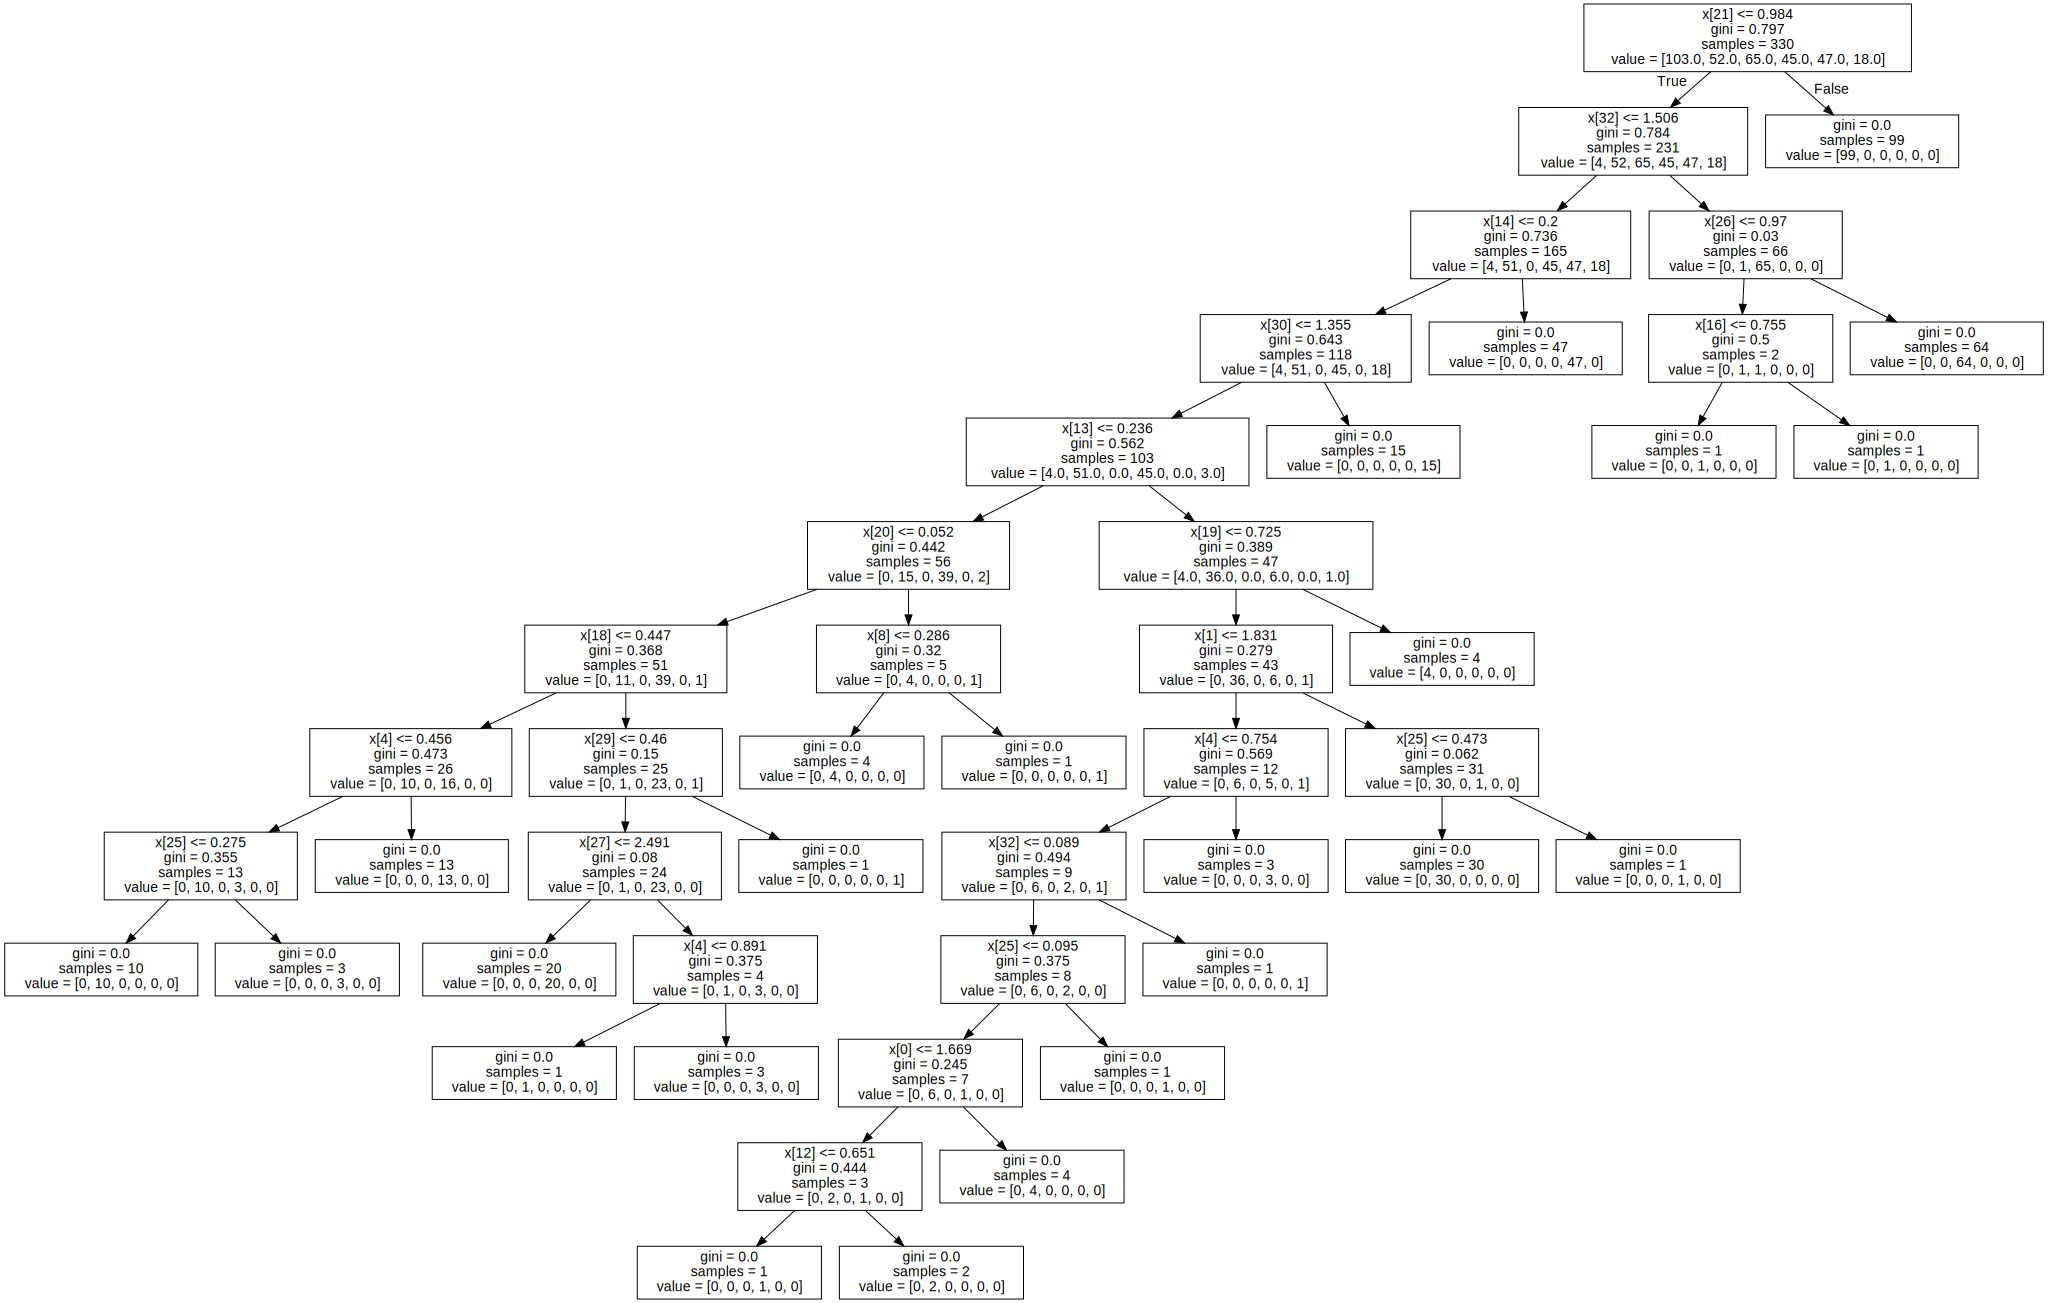

In [11]:
# Include decision tree visualization here
import graphviz
for i, val in enumerate(derm_metadata):
    print(f"Attribute {i}: {val}")
print("="*20)
result_key = ["psoriasis", "seboreicdermatitis", "lichenplanus", "pityriasisrosea", "cronicdermatitis", "pityriasisrubrapilaris"]
for i, result in enumerate(result_key):
    print(f"Diagnosis {i}: {result}")
graphviz.Source(tree.export_graphviz(best_tree), format="png")
# Discuss what the model has learned

### Discussion
I was quite impressed with the results! After training, the models would score between <em>85-98%</em> with some test data. I was surprised to see that the ones with the <b>most pruning</b> usually did better. I mean, I trusted y'all before, but it was kind of crazy to see overfitting happening in front of me.<br><br>

The attributes chosed varied a bit (due to the random selection obviously), but the most common first split was on feature <b>19</b>, <em>"Clubbing of the rete ridges"</em>. Other common distinguishing factors were <b>26<b> (<em>"Vasculation and damage of basal layer"</em>), <b>27</b> (<em>"Spongiosis"</em>), and <b>30</b> (<em>perifollicular parakeratosis</em>). Unfortunately, it seems like the model was still a bit overfit, since many of the leaves only had one item in them at the end. This, I think, is because the dataset was quite wide; the number of attributes was only about a tenth of the number of examples. Thus, I think some degree of overfitting is inevitable without more data.<br><br>
    
I suppose now the biggest test is going to be running this by my uncle, a dermatologist. This Christmas break when he overheard I was going to be doing an AI class, he told me that the big idea in AI he's had for a while was, and I quote, "like 20 questions but to diagnose skin cancers". Perhaps with more data, it might be worth investing in little handheld devices to sell. :)
    

## 6. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).